# Exercise 3: Hodgkin-Huxley model

In the lecture, the Hodgkin-Huxley model was defined by the following set of differential equations:

<center>
<div class="alert alert-block alert-info">
\begin{eqnarray}
C\frac{dV}{dt} &=& I - \bar g_{K^+} n^4 (V - E_{K^+}) - \bar g_{Na^+} m^3 h(V - E_{Na^+} ) - g_L (V - E_L) \\ 
\frac{dn}{dt} &=& \frac{n_\infty (V) - n}{\tau_n (V)} \\
\frac{dm}{dt} &=& \frac{m_\infty (V) - m}{\tau_m(V)} \\
\frac{dh}{dt} &=&  \frac{h_\infty (V) - h}{\tau_h (V)}
\end{eqnarray}
</div>
</center>

It is convenient to rewrite the last three equations in the form

\begin{equation}
\frac{dx}{dt} = \alpha_x(V)(1 - x) - \beta_x (V )x  \qquad \mbox{where} \ x \in \{n, m, h\}.
\end{equation}

The coefficients $\alpha_x (V )$ and $\beta_x (V )$ represent the (voltage-dependent) activation and inactivation rates, respectively, for the gate $x$. With these coefficients, the steady-state activation variables $x_\infty(V )$ and the time constants $\tau_x(V )$ in the Hodgkin-Huxley equations (Box 1) are given by

\begin{equation}
x_\infty (V) = \frac{\alpha_x (V)}{\alpha_x (V) + \beta_x (V)} \qquad \mbox{and} \qquad
\tau_x (V ) = \frac 1{\alpha_x (V) + \beta_x(V)}.
\end{equation}

In this exercise the task is to make and test a computer program that solves the Hodgkin-Huxley model (Box 1) for a rectangular input-current pulse

\begin{equation}
I(t) = \begin{cases} I_{\mbox{max}} & t_{\mbox{stim,on}} \le t \le t_{\mbox{stim,off}} \\ 0 & \mbox{else} \end{cases}
\end{equation}

and with the initial condition

\begin{eqnarray}
V(0) &=& V_{\mbox{rest}}  \\
n(0) &=& n_\infty (V_{\mbox{rest}}) \\
m(0) &=& m_\infty (V_{\mbox{rest}}) \\
h(0) &=& h_\infty (V_{\mbox{rest}})\;.
\end{eqnarray}

Here, $V_{\mbox{rest}}$ denotes the resting potential of the neuron, i.e. the stationary membrane potential in the absence of any input $I$. 

Many numerical schemes exist for solving ('evaluating') sets of differential equations. Here you can use the simplest one, that is the _forward Euler_ method. In this scheme the differential dynamics $dy/dt = f(y, t)$ is approximated by

\begin{align*}
&\frac{y(t) - y(t - \Delta t)}{\Delta t} = f (y(t - \Delta t), t - \Delta t) \nonumber \\
&\Rightarrow  y(t) = y(t - \Delta t) + \Delta t \cdot f (y(t - \Delta t), t - \Delta t).
\end{align*}

__(i)__  Evaluate the HH-equations (Box 1) at the times $t \in \{0,\ \Delta t,\ 2\Delta t,\ \dots ,\ T - \Delta t,\ T \}$ assuming a constant input current $I_{\mbox{max}} = 10\ \mu A/cm^2$  by using the numerical forward Euler method. To this end, use the Python-script skeleton provided below. Complete the following
functions (search for text: `$## TO BE IMPLEMENTED` in the cells):

* `stimulus()`
* `update()`
* `simulate()`

A detailed description of each of these functions, i.e. what they are _supposed_ to do, is found in the documentation
(see docstring of the respective function). Default parameter values and parameter functions are provided in
Table 1 below. Note that these parameters are already implemented in the function `set\_parameters()`. Plot the
input current $I(t)$ and the resulting membrane potential $V(t)$ (the code for plotting is already implemented in
the script skeleton). A correct implementation should lead to a figure as shown in Figure 1.

<img src="fig_Ex3.png" width = "600">


__(ii)__ Set the stimulus amplitude to a negative value, that is, $I_{\mbox{max}} = -10\ \mu A/cm^2$, and plot the resulting membrane potential (when as in (i)  $t_{\mbox{stim,on}}=5$ ms and $t_{\mbox{stim,off}}=30$ ms). 
Can you explain the result?

__(iii)__ Use the code you have as a starting point for finding the $f-I$ curve of the HH neuron.  Note that for some 'subthreshold' currents, the HH-model responds by firing spikes for a while before becoming silent. This corresponds to zero firing rate here. What is the threshold current for sustained firing for the present version of the
HH-model?

<img src="Table.png" width = "600">


In [1]:
%pylab notebook
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_parameters():
    '''
    Define simulation, stimulus and neuron parameters and stores values in parameter dictionary p.

    Returns:
    --------
    p : dict
        Parameter dictionary.
      
    '''
    ## store parameters in dictionary
    p = {}
  
    ## simulation parameters
    p['T'] = 50.                ## simulation time (ms)
    p['dt'] = 0.025              ## simulation time resolution (ms)

    ## stimulus parameters
    p['I_amp'] = -10.           ## input current amplitude (uA/cm2)
    p['t_stim_on'] = 5.            ## stimulus-on time (ms)
    p['t_stim_off'] = 30           ## stimulus-off time (ms)

    ## neuron parameters
    p['V_rest'] = -65.             ## resting potential (mV)
    p['Cm'] = 1.               ## membrane capacitance (uF/cm2)
    p['gbar_Na'] = 120.             ## max. Na conductance (mS/cm2)
    p['gbar_K'] = 36.               ## max K conductance (mS/cm2)
    p['gbar_l'] = 0.3              ## leak conductance (mS/cm2)
    p['E_Na'] = 50.              ## Na reversal potentail (mV)
    p['E_K'] = -77.             ## K reversal potentail (mV)
    p['E_l'] = -54.387          ## Leak reversal potentail (mV)

    ## voltage dependence of gate variables    
    ### K activation
    p['alpha_n'] = np.vectorize(lambda v: 0.01*(v+55.) / (1.-np.exp(-(v + 55.)/10.)) 
                                if v != -55. else 0.1) ## activation rate (1/ms)
    p['beta_n'] = lambda v: 0.125*np.exp(-(v+65.)/80.) ## inactivation rate (1/ms)
    
    ### Na activation
    p['alpha_m'] = np.vectorize(lambda v: 0.1*(v + 40.)/(1.-np.exp(-(v + 40.)/10.)) 
                                if v != -40. else 1)  ## activation rate (1/ms)
    p['beta_m'] = lambda v: 4.*np.exp(-(v+65.)/18.)   ## inactivation rate (1/ms)
    
    ### Na inactivation
    p['alpha_h'] = lambda v: 0.07*np.exp(-(v+65.)/20.)  ## activation rate (1/ms)
    p['beta_h'] = lambda v: 1./(1.+np.exp(-(v + 35.)/10.)) ## inactivation rate (1/ms)

    derived_parameters(p)  ## add derived parameters to dictionary (see below)

    ## HINT: Storing parameters in dictionaries simplifies function definitions by 
    ## reducing number of arguments (see below).
    
    return p

In [3]:
def derived_parameters(p):
    '''
    Set derived parameters, i.e. parameters which are fully defined by parameters in p.

    Parameters:
    -----------
    p: dict
       Parameter dictionary
     
    Returns:
    --------
    nothing (p is modified "on-the-fly").
    
    '''
    
    p['time'] = np.arange(0, p['T']+p['dt'], p['dt'])                          ## time array (ms)
    p['n_inf'] = lambda v: p['alpha_n'](v)/(p['alpha_n'](v) + p['beta_n'](v)) ## steady-state K activation
    p['tau_n'] = lambda v: 1./(p['alpha_n'](v) + p['beta_n'](v))              ## (ms)
    p['m_inf'] = lambda v: p['alpha_m'](v)/(p['alpha_m'](v) + p['beta_m'](v)) ## steady-state Na activation
    p['tau_m'] = lambda v: 1./(p['alpha_m'](v) + p['beta_m'](v))              ## (ms)
    p['h_inf'] = lambda v: p['alpha_h'](v)/(p['alpha_h'](v) + p['beta_h'](v)) ## steady-state Na inactivation
    p['tau_h'] = lambda v: 1./(p['alpha_h'](v) + p['beta_h'](v))              ## (ms)

In [24]:
def stimulus(p):
    '''
    Consctructs array I of input currents with

    I(t) = p['I_amp']        for p['t_stim_on'] <= t <= p['t_stim_off']
    I(t) = 0.0               else.

    (i.e. current pulse of length p['t_stim_off']-p['t_stim_on']).
    
    Parameters:
    -----------
    p: dict
       Parameter dictionary
     
    Returns:
    --------
    I: ndarray
       Array of input currents with with len(I)=len(p['time']).

    '''
    I = np.zeros(len(p["time"]))
    stimulus = np.logical_and(p['time']>p['t_stim_on'],p['time']<p['t_stim_off'])
    I[stimulus] = p['I_amp']

    return I

In [25]:
def update(Vm, m, h, n, I, p):
    '''
    Updates neuron state (Vm,m,h,n) from time step i-1 to time step i.

    Parameters:
    -----------
    Vm: float
        Membrane potentential at time step i-1.
     m: float
        Na activation at time step i-1.
     h: float
        Na inactivation at time step i-1.
     n: float
        K activation at time step i-1.
     I: float
        Input current at time step i-1.
     p: dict
        Parameter dictionary
    
    Returns:
    --------
    Vm: float
        Membrane potentential at time step i.
     m: float
        Na activation at time step i.
     h: float
        Na inactivation at time step i.    
     n: float
        K activation at time step i.
  
    '''
    dt = p['dt']
    Vm_new = Vm + dt/p['Cm']*(I - \
                        p['gbar_K']*n**4*(Vm - p['E_K']) - \
                        p['gbar_Na']*m**3*h*(Vm - p['E_Na']) - \
                        p['gbar_l']*(Vm - p['E_l']))
    n_new = n + dt*(p['n_inf'](Vm_new) - n)/p['tau_n'](Vm_new)
    m_new = m + dt*(p['m_inf'](Vm_new) - m)/p['tau_m'](Vm_new)
    h_new = h + dt*(p['h_inf'](Vm_new) - h)/p['tau_h'](Vm_new)
    
    return Vm_new, m_new, h_new, n_new

In [26]:
def simulate(p):
    '''
    1) Initialises state variables Vm, m, h, n with respective values at resting potential p['V_rest'].
    2) Constructs and returns array I of input currents by calling stimulus().
    3) Constructs array Vm of membrane potentials by calling update() in each time step.

    Parameters:
    -----------
    p: dict
       Parameter dictionary
       
    Returns:
    --------
    Vm: ndarray
        Array of membrane potentials with len(Vm)=len(p['time']).
     I: ndarray
        Array of input currents with len(I)=len(p['time']).

    '''
    V_rest = p['V_rest']
    n = p['n_inf'](V_rest)
    m = p['m_inf'](V_rest)
    h = p['h_inf'](V_rest)
    I = stimulus(p)
    N = I.shape[0]
    Vm = np.zeros(N)
    Vm[0] = V_rest
    
    for i in range(N-1):
        Vm[i+1], m, h, n = update(Vm[i], m, h, n, I[i], p)
    
    return Vm, I

## Main simulation:

<IPython.core.display.Javascript object>


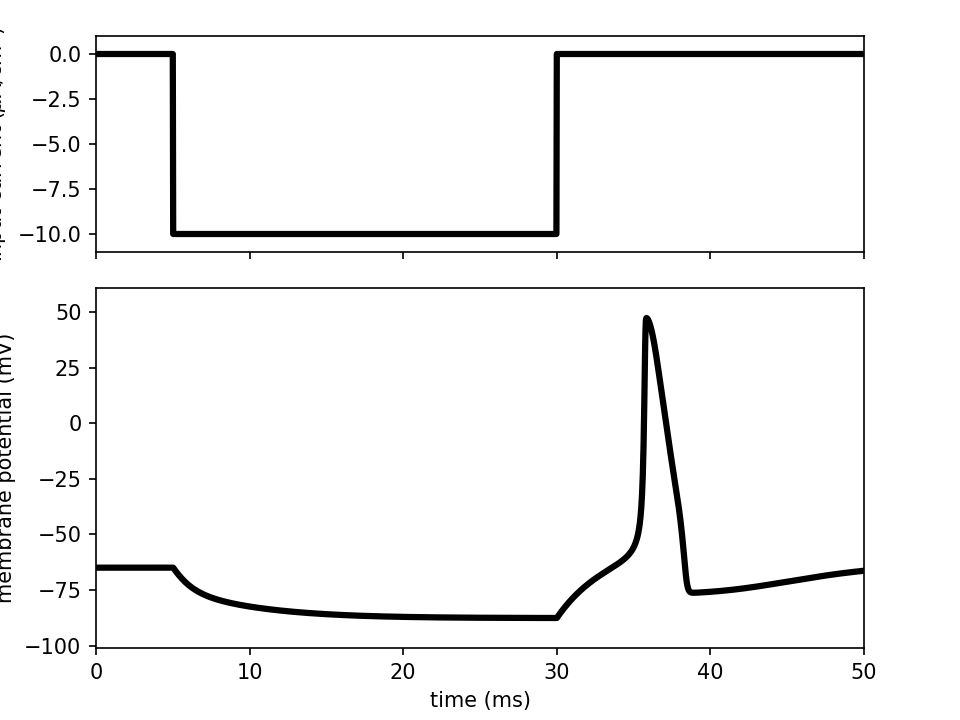

In [27]:
## set parameters
p = set_parameters()

## simulate
Vm, I = simulate(p)

## plot results
figure(1)
clf()

### input current
sp1 = subplot(211)
plot(p['time'], I, 'k-', lw=3)
ylabel('input current ($\mu$A/cm$^2$)')
xlim(p['time'][0], p['time'][-1])
offset = 0.1*np.abs(np.max(I)-np.min(I))
ylim(np.min(I)-offset, np.max(I)+offset)
sp1.set_position([0.1, 0.65, 0.8, 0.3])
setp(gca(), xticklabels=[])

### membrane potential 
sp2 = subplot(212)
plot(p['time'], Vm, 'k-', lw=3)
ylabel('membrane potential (mV)')
xlabel('time (ms)')
xlim(p['time'][0], p['time'][-1])
offset = 0.1*np.abs(np.max(Vm)-np.min(Vm))
ylim(np.min(Vm)-offset, np.max(Vm)+offset)
sp2.set_position([0.1, 0.1, 0.8, 0.5])

savefig('exercise_3_result.png')  ## saves figure as pdf file
